In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
from itertools import islice, chain
from collections import defaultdict
import hashlib
import os
import math
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp
from simulation import Simulation
import ipyparallel as ipp
import ipywidgets
import time

In [2]:
variables_all = {
    'min_tests_daily_proportion': (0.001, 0.01),
    'max_tests_daily_proportion': (0.02, 0.1),
    'desired_positive_proportion': (0.01, 0.5),
}

problem = {
    'num_vars': len(variables_all),
    'names': variables_all.keys(),
    'bounds': [list(x) for x in variables_all.values()]
}

samples = None

In [3]:
def compute_row_hash(row):
    return hashlib.sha1(np.array(row)).hexdigest()

def generate_samples_df(variables, sampling_fun):
    samples = sampling_fun(problem)
    
    df = pd.DataFrame(samples, columns=variables.keys())
    
    df['hash'] = df.apply(compute_row_hash, axis=1)
    df.set_index('hash', inplace=True)
    return df

def spit_params_dicts(samples_df):
    for idx, row in df.iterrows():
        params = dict(row)
        params['run_id'] = idx
        yield params

In [4]:
def load_results_if_present(result_id):
    result_file = f'results/r_{result_id}.csv'
    return pd.read_csv(result_file, index_col=0) if os.path.isfile(result_file) else None

In [5]:
pdf = generate_samples_df(variables_all, lambda x: ms.sample(x, 1000, seed=1234))
pdf

,min_tests_daily_proportion,max_tests_daily_proportion,desired_positive_proportion
hash,,,
391599cb126342b2118da600ab2bd21943269728,0.010,0.100000,0.500000
bb940f32474486292190a20bcebb862b2eda6a2e,0.004,0.100000,0.500000
0ea26d6f201c03c401a4248fb8a5300e45e066e8,0.004,0.046667,0.500000
7bcfc1ef2e2db066e8151beab503bcb05c162702,0.004,0.046667,0.173333
f6e3cee02eaeb4de00689579e57582a7a78fd0e5,0.007,0.020000,0.336667
...,...,...,...
0c35bdc81feeeff74e8d95bff4b62d5c42bcf863,0.007,0.046667,0.010000
3a9a03797181f816c444d36e4d93187fead8f60f,0.010,0.100000,0.010000
d314b66a89bea3d2d11876288866db7e396cf3b8,0.010,0.046667,0.010000


In [137]:
def progress_bar(ar):
    # We create a progress bar.
    w = ipywidgets.IntProgress()
    # The maximum value is the number of tasks.
    w.max = len(ar.msg_ids)
    # We display the widget in the output area.
    display(w)
    # Repeat:
    while not ar.ready():
        # Update the widget's value with the
        # number of tasks that have finished
        # so far.
        w.value = ar.progress
        time.sleep(.1)
    w.value = w.max

In [138]:
rc = ipp.Client()

In [139]:
view = rc.load_balanced_view()

In [144]:
def compute(x):
    import os
    import pandas as pd
    from simulation import Simulation
    
    def load_results_if_present(result_id):
        result_file = f'results/r_{result_id}.csv'
        return pd.read_csv(result_file, index_col=0) if os.path.isfile(result_file) else None
    
    idx, row = x
    results = load_results_if_present(idx)
    if results is None:
        param_dict = row.to_dict()
        param_dict['quiet'] = True
        param_dict['visualize'] = False
        param_dict['verbose'] = False
        param_dict['print_sum'] = False
        param_dict['run_id'] = idx

        sim = Simulation(**param_dict)
        sim.run()
        
        results = load_results_if_present(idx)
        assert results is not None
    return len(results)

In [145]:
ar = view.map_async(compute, pdf.iterrows())
progress_bar(ar)

IntProgress(value=0, max=4000)

In [146]:
len(ar.result())

4000

In [6]:
def compute_metrics(result_df):
    last_record = result_df.iloc[-1]
    pop_size = 2000
    fatalities = last_record['fatalities'] / pop_size
    unaffected = last_record['susceptible'] / pop_size
    sev2 = last_record['severity2'] / pop_size
    
    result_df['known%'] = result_df['infected_known'] / result_df['infected']
    maxin = result_df.loc[result_df['infected'].idxmax()]['known%']
    maxink = result_df.loc[result_df['infected_known'].idxmax()]['known%']
    unknown75 = (1 - result_df['known%']).describe()['75%']
    unknown50 = (1 - result_df['known%']).describe()['50%']

    return {
        'fata': fatalities,
        'unaf': unaffected,
        'sev2': sev2,
        'maxin%': maxin,
        'maxink%': maxink,
        'uk75': unknown75,
        'uk50': unknown50
    }

In [7]:
params = []
res_dict = defaultdict(list)

for idx, row in pdf.iterrows():
    results = load_results_if_present(idx)
    assert results is not None
    
    metrics = compute_metrics(results)
    for k, v in metrics.items():
        res_dict[k].append(v)
    
    params.append(list(row))


for k in res_dict.keys():
    res_dict[k] = np.asarray(res_dict[k])

params = np.asarray([np.asarray(ps) for ps in params])

In [74]:
pd.DataFrame(ma.analyze(problem, params, res_dict['fata'], seed=1234))

,names,mu,mu_star,sigma,mu_star_conf
0,min_tests_daily_proportion,-0.001065,0.004860,0.006534,0.000964
1,max_tests_daily_proportion,0.000457,0.005152,0.006295,0.000792
2,desired_positive_proportion,-0.001695,0.006420,0.007656,0.000913


In [13]:
def make_adf(feature):
    adf = pd.DataFrame(ma.analyze(problem, params, res_dict['fata'], seed=1234)).set_index('names')
    display(adf)
    adf.plot(kind='bar', y='mu', yerr='sigma', grid=True)
    adf.plot(kind='bar', y='mu_star', yerr='mu_star_conf', grid=True)

- `Mu` is the mean effect caused by the input parameter being moved over its range.
- `Sigma` is the standard deviation of the mean effect.
- `Mu_star` is the mean absolute effect.

,mu,mu_star,sigma,mu_star_conf
names,,,,
min_tests_daily_proportion,-0.000497,0.004429,0.006159,0.000261
max_tests_daily_proportion,0.000421,0.004924,0.006233,0.000247
desired_positive_proportion,-0.001712,0.005687,0.007091,0.000315


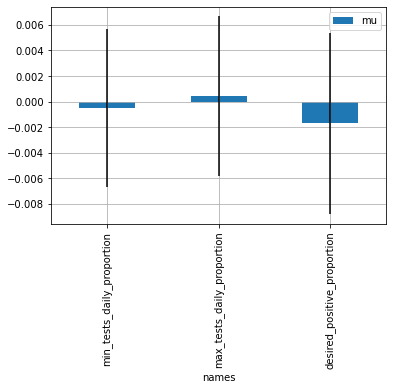

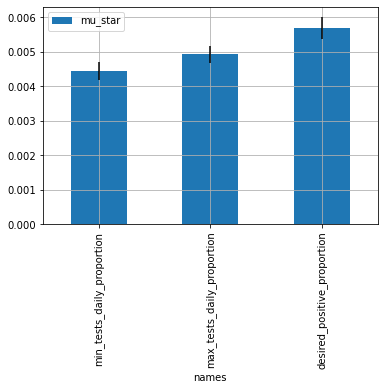

In [14]:
make_adf('fata')

,mu,mu_star,sigma,mu_star_conf
names,,,,
min_tests_daily_proportion,-0.000497,0.004429,0.006159,0.000261
max_tests_daily_proportion,0.000421,0.004924,0.006233,0.000247
desired_positive_proportion,-0.001712,0.005687,0.007091,0.000315


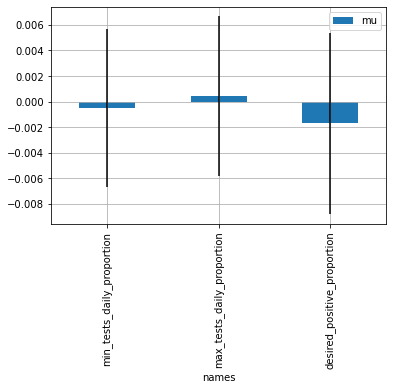

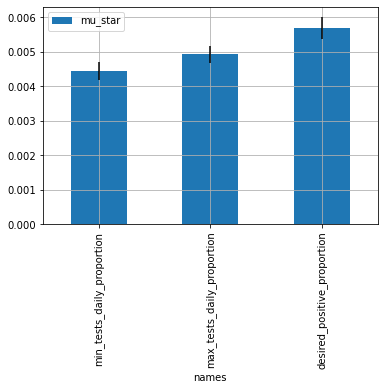

In [15]:
make_adf('unaf')

,mu,mu_star,sigma,mu_star_conf
names,,,,
min_tests_daily_proportion,-0.000497,0.004429,0.006159,0.000261
max_tests_daily_proportion,0.000421,0.004924,0.006233,0.000247
desired_positive_proportion,-0.001712,0.005687,0.007091,0.000315


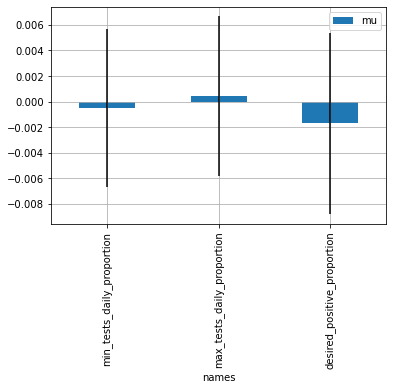

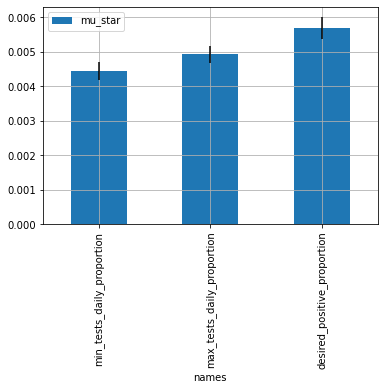

In [16]:
make_adf('sev2')

,mu,mu_star,sigma,mu_star_conf
names,,,,
min_tests_daily_proportion,-0.000497,0.004429,0.006159,0.000261
max_tests_daily_proportion,0.000421,0.004924,0.006233,0.000247
desired_positive_proportion,-0.001712,0.005687,0.007091,0.000315


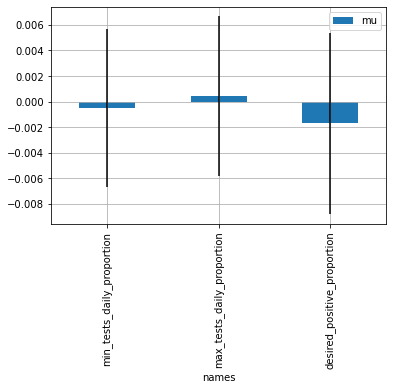

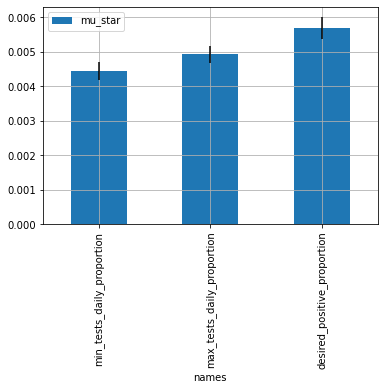

In [17]:
make_adf('maxin%')

,mu,mu_star,sigma,mu_star_conf
names,,,,
min_tests_daily_proportion,-0.000497,0.004429,0.006159,0.000261
max_tests_daily_proportion,0.000421,0.004924,0.006233,0.000247
desired_positive_proportion,-0.001712,0.005687,0.007091,0.000315


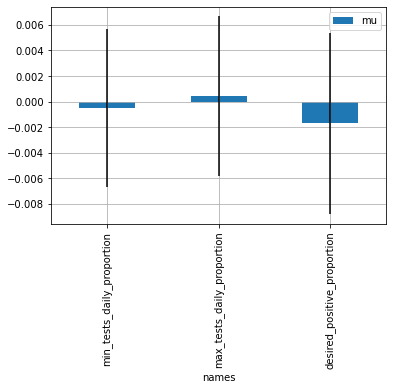

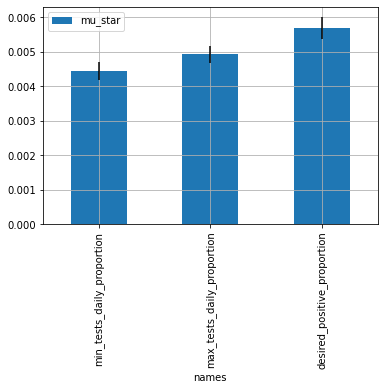

In [18]:
make_adf('maxink%')

,mu,mu_star,sigma,mu_star_conf
names,,,,
min_tests_daily_proportion,-0.000497,0.004429,0.006159,0.000261
max_tests_daily_proportion,0.000421,0.004924,0.006233,0.000247
desired_positive_proportion,-0.001712,0.005687,0.007091,0.000315


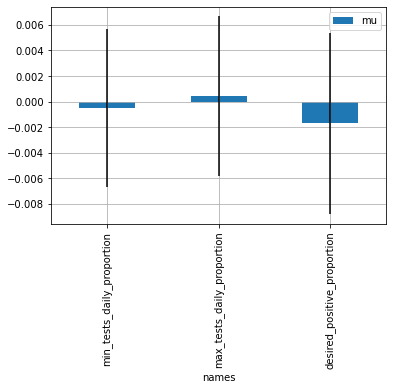

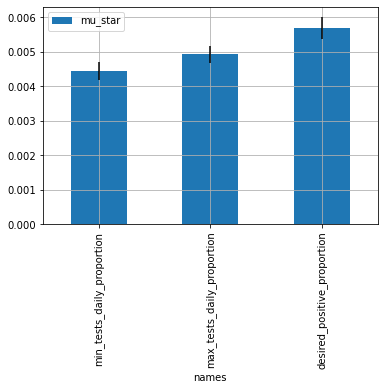

In [19]:
make_adf('uk75%')

,mu,mu_star,sigma,mu_star_conf
names,,,,
min_tests_daily_proportion,-0.000497,0.004429,0.006159,0.000261
max_tests_daily_proportion,0.000421,0.004924,0.006233,0.000247
desired_positive_proportion,-0.001712,0.005687,0.007091,0.000315


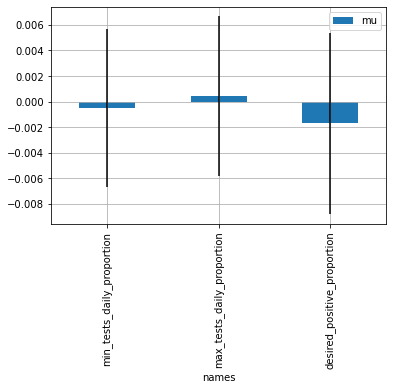

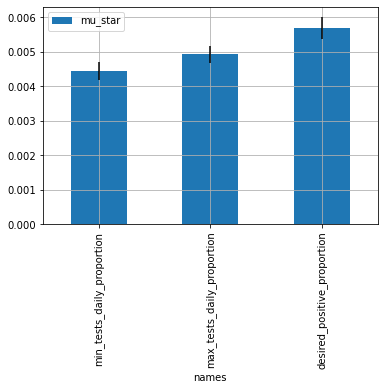

In [20]:
make_adf('uk50%')